In [ ]:
JAI SHRI RAM

In [ ]:
!pip install -q faiss-cpu rank_bm25 sentence-transformers transformers accelerate


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.3/31.3 MB 23.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 36.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 16.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 42.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 77.6 MB/s eta 0:00:00


In [ ]:
import json
import pandas as pd

# Load the JSON file correctly
with open('/content/Ecommerce_FAQ_Chatbot_dataset.json', 'r') as f:
    data = json.load(f)

# Convert to DataFrame
faq_data = data["questions"]
df = pd.DataFrame(faq_data)

# Extract questions and answers
corpus = df['question'].tolist()
answers = df['answer'].tolist()


In [ ]:
import nltk
from rank_bm25 import BM25Okapi

nltk.download('punkt', force=True)
nltk.download('punkt_tab', force=True)
from nltk.tokenize import word_tokenize

tokenized_corpus = [word_tokenize(doc.lower()) for doc in corpus]
bm25 = BM25Okapi(tokenized_corpus)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [ ]:
from huggingface_hub import login

# Paste your token here (or use an environment variable securely)
login(token="")  # 🔒 Keep this secure!


In [ ]:
from sentence_transformers import SentenceTransformer

# Load top-quality embeddings for RAG/FAQ tasks
embedder = SentenceTransformer('intfloat/e5-base-v2')


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/387 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/67.6k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/57.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/650 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/314 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/200 [00:00<?, ?B/s]

In [ ]:
from sklearn.preprocessing import normalize
import faiss
import numpy as np

# Embed corpus with "passage: " prefix (E5 format)
corpus_texts = [f"passage: {q}" for q in corpus]
corpus_embeddings = embedder.encode(corpus_texts, convert_to_numpy=True)
corpus_embeddings = normalize(corpus_embeddings, axis=1)

# Build FAISS index with cosine similarity
dimension = corpus_embeddings.shape[1]
faiss_index = faiss.IndexFlatIP(dimension)
faiss_index.add(corpus_embeddings)


In [ ]:
def search_bm25(query, top_k=3):
    tokenized_query = word_tokenize(query.lower())
    scores = bm25.get_scores(tokenized_query)
    top_indices = np.argsort(scores)[::-1][:top_k]
    return [(corpus[i], answers[i]) for i in top_indices]

def search_faiss(query, top_k=3):
    query_text = f"query: {query}"
    query_embedding = embedder.encode([query_text], convert_to_numpy=True)
    query_embedding = normalize(query_embedding, axis=1)
    D, I = faiss_index.search(query_embedding, top_k)
    return [(corpus[i], answers[i]) for i in I[0]]


In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline
import torch

model_id = "Qwen/Qwen2.5-3B-Instruct"  # Or swap with another
tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForCausalLM.from_pretrained(model_id, device_map="auto", torch_dtype=torch.float16)

llm = pipeline("text-generation", model=model, tokenizer=tokenizer)


tokenizer_config.json:   0%|          | 0.00/7.30k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/7.03M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/661 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/35.6k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/2.20G [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/3.97G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/242 [00:00<?, ?B/s]

Device set to use cuda:0


In [ ]:
def generate_hybrid_rag_answer_verbose(query, llm, top_k=3):
    # Step 1: Retrieve from FAISS and BM25
    faiss_results = search_faiss(query, top_k)
    bm25_results = search_bm25(query, top_k)

    # Merge + deduplicate
    combined = {}
    for q, a in faiss_results + bm25_results:
        combined[q] = a

    # Format context
    hybrid_context = "\n".join([f"Q: {q}\nA: {a}" for q, a in combined.items()])

    # LLM Prompt
    prompt = f"""You are a helpful e-commerce assistant. Use the following FAQ context to answer the user's question clearly and only once. Avoid repetition.

FAQ Context:
{hybrid_context}

User Question: {query}
Answer:"""

    # Generate response
    response = llm(prompt, max_new_tokens=200, do_sample=False)[0]["generated_text"]
    raw_answer = response.split("Answer:")[-1].strip()

    # Optional cleanup to remove redundancy
    lines = raw_answer.split('\n')
    seen = set()
    final_lines = []
    for line in lines:
        line_clean = line.strip()
        if line_clean and line_clean not in seen and not line_clean.lower().startswith("based on"):
            final_lines.append(line_clean)
            seen.add(line_clean)

    final_answer = " ".join(final_lines)

    return final_answer, faiss_results, bm25_results


In [ ]:
query = "Can I return a product that was bought on discount?"

print("🧠 Hybrid RAG Answer (FAISS + BM25):")
answer, faiss_res, bm25_res = generate_hybrid_rag_answer_verbose(query, llm)

print("\n🔍 FAISS Retrieved:")
for q, a in faiss_res:
    print(f"Q: {q}\nA: {a}\n")

print("🔍 BM25 Retrieved:")
for q, a in bm25_res:
    print(f"Q: {q}\nA: {a}\n")

print("🧠 Final Answer:")
print(answer)


The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


🧠 Hybrid RAG Answer (FAISS + BM25):

🔍 FAISS Retrieved:
Q: Can I return a product if it was purchased during a sale or with a discount?
A: Yes, you can return a product purchased during a sale or with a discount. The refund will be processed based on the amount paid after the discount.

Q: Can I return a product if it was purchased with a discount code?
A: Yes, you can return a product purchased with a discount code. The refund will be processed based on the amount paid after the discount.

Q: Can I return a product if it was purchased during a promotional event?
A: Yes, you can return a product purchased during a promotional event. The refund will be processed based on the amount paid after any applicable discounts.

🔍 BM25 Retrieved:
Q: Can I return a product if it was purchased with a discount code?
A: Yes, you can return a product purchased with a discount code. The refund will be processed based on the amount paid after the discount.

Q: Can I return a product if it was purchased 

In [ ]:
import random
from tqdm import tqdm

def evaluate_retrievers(k=3, num_samples=30):
    correct_faiss = 0
    correct_bm25 = 0
    both_correct = 0

    indices = random.sample(range(len(corpus)), num_samples)

    for idx in tqdm(indices):
        query = corpus[idx]
        expected_answer = answers[idx]

        faiss_hits = [a for _, a in search_faiss(query, k)]
        bm25_hits = [a for _, a in search_bm25(query, k)]

        faiss_ok = expected_answer in faiss_hits
        bm25_ok = expected_answer in bm25_hits

        if faiss_ok:
            correct_faiss += 1
        if bm25_ok:
            correct_bm25 += 1
        if faiss_ok and bm25_ok:
            both_correct += 1

    print(f"📊 FAISS Recall@{k}: {correct_faiss}/{num_samples} = {correct_faiss / num_samples:.2f}")
    print(f"📊 BM25 Recall@{k}: {correct_bm25}/{num_samples} = {correct_bm25 / num_samples:.2f}")
    print(f"🔁 Both retrieved correctly: {both_correct}/{num_samples} = {both_correct / num_samples:.2f}")


In [ ]:
evaluate_retrievers(k=3, num_samples=30)


100%|██████████| 30/30 [00:00<00:00, 45.28it/s]

📊 FAISS Recall@3: 30/30 = 1.00
📊 BM25 Recall@3: 30/30 = 1.00
🔁 Both retrieved correctly: 30/30 = 1.00


In [ ]:
!pip install rouge-score nltk

import random
from tqdm import tqdm
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from rouge_score import rouge_scorer
import pandas as pd

def evaluate_rag_pipeline_with_llm(llm, k=3, num_samples=30):
    results = []
    indices = random.sample(range(len(corpus)), num_samples)

    bleu_scores = []
    rouge_1_scores = []
    rouge_l_scores = []

    for idx in tqdm(indices):
        query = corpus[idx]
        expected_answer = answers[idx]

        # Get generated RAG answer
        generated_answer, faiss_res, bm25_res = generate_hybrid_rag_answer_verbose(query, llm, top_k=k)

        # BLEU Score
        reference = [expected_answer.split()]
        hypothesis = generated_answer.split()
        bleu = sentence_bleu(reference, hypothesis, smoothing_function=SmoothingFunction().method1)
        bleu_scores.append(bleu)

        # ROUGE Score
        scorer = rouge_scorer.RougeScorer(['rouge1', 'rougeL'], use_stemmer=True)
        scores = scorer.score(expected_answer, generated_answer)
        rouge_1_scores.append(scores['rouge1'].fmeasure)
        rouge_l_scores.append(scores['rougeL'].fmeasure)

        results.append({
            "query": query,
            "expected_answer": expected_answer,
            "generated_answer": generated_answer,
            "bleu": bleu,
            "rouge1": scores['rouge1'].fmeasure,
            "rougeL": scores['rougeL'].fmeasure
        })

    # Averages
    avg_bleu = sum(bleu_scores) / len(bleu_scores)
    avg_rouge1 = sum(rouge_1_scores) / len(rouge_1_scores)
    avg_rougeL = sum(rouge_l_scores) / len(rouge_l_scores)

    print(f"\n📊 Average BLEU: {avg_bleu:.4f}")
    print(f"📊 Average ROUGE-1 F1: {avg_rouge1:.4f}")
    print(f"📊 Average ROUGE-L F1: {avg_rougeL:.4f}")

    return pd.DataFrame(results)


  Preparing metadata (setup.py) ... done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=53b72e9f3cac657005074ab1fe6b022425e10fb0c145cb2b69b40e1a1213231d
  Stored in directory: /root/.cache/pip/wheels/1e/19/43/8a442dc83660ca25e163e1bd1f89919284ab0d0c1475475148
Successfully built rouge-score


In [ ]:
df_eval = evaluate_rag_pipeline_with_llm(llm, k=3, num_samples=30)
df_eval.head()


 20%|██        | 6/30 [00:39<02:20,  5.84s/it]You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
100%|██████████| 30/30 [02:27<00:00,  4.93s/it]


📊 Average BLEU: 0.5027
📊 Average ROUGE-1 F1: 0.6264
📊 Average ROUGE-L F1: 0.6258


,query,expected_answer,generated_answer,bleu,rouge1,rougeL
0,Can I order a product if it is listed as 'comi...,If a product is listed as 'coming soon' and av...,If a product is listed as 'coming soon' and av...,1.000000,1.000000,1.000000
1,Can I order a product if it is listed as 'out ...,"If a product is available for pre-order, you c...","If a product is available for pre-order, you c...",1.000000,1.000000,1.000000
2,Can I return a product if it was a final sale ...,Final sale items are usually non-returnable an...,Final sale items are usually non-returnable an...,0.172720,0.316940,0.316940
3,Can I request a product that is listed as 'out...,We do not offer reservations for out-of-stock ...,We do not offer reservations for out-of-stock ...,0.381744,0.568421,0.568421
4,Can I request a product if it is not listed on...,"If a product is not listed on our website, it ...","If a product is not listed on our website, it ...",1.000000,1.000000,1.000000


from matplotlib import pyplot as plt
_df_0['bleu'].plot(kind='hist', bins=20, title='bleu')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['rouge1'].plot(kind='hist', bins=20, title='rouge1')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['rougeL'].plot(kind='hist', bins=20, title='rougeL')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_3.groupby('query').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_4.groupby('expected_answer').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_5.groupby('generated_answer').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_6.plot(kind='scatter', x='bleu', y='rouge1', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_7.plot(kind='scatter', x='rouge1', y='rougeL', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_8['bleu'].plot(kind='line', figsize=(8, 4), title='bleu')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_9['rouge1'].plot(kind='line', figsize=(8, 4), title='rouge1')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_10['rougeL'].plot(kind='line', figsize=(8, 4), title='rougeL')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['expected_answer'].value_counts()
    for x_label, grp in _df_11.groupby('query')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('query')
_ = plt.ylabel('expected_answer')

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['generated_answer'].value_counts()
    for x_label, grp in _df_12.groupby('expected_answer')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('expected_answer')
_ = plt.ylabel('generated_answer')

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_13['query'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_13, x='bleu', y='query', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_14['expected_answer'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_14, x='bleu', y='expected_answer', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_15['generated_answer'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_15, x='bleu', y='generated_answer', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_16['query'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_16, x='rouge1', y='query', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

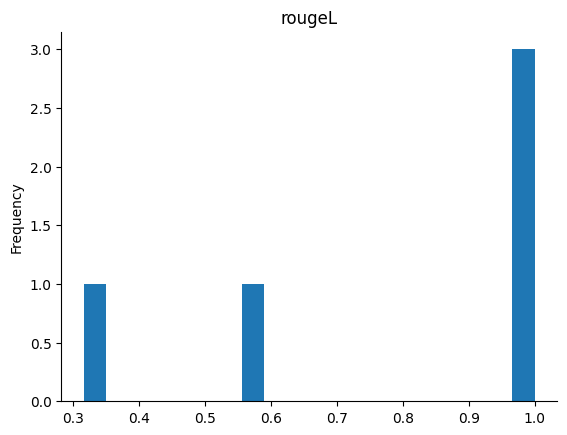

In [ ]:
from matplotlib import pyplot as plt
_df_2['rougeL'].plot(kind='hist', bins=20, title='rougeL')
plt.gca().spines[['top', 'right',]].set_visible(False)

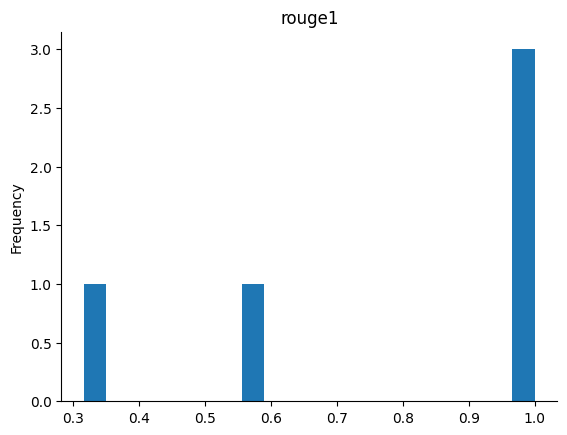

In [ ]:
from matplotlib import pyplot as plt
_df_1['rouge1'].plot(kind='hist', bins=20, title='rouge1')
plt.gca().spines[['top', 'right',]].set_visible(False)

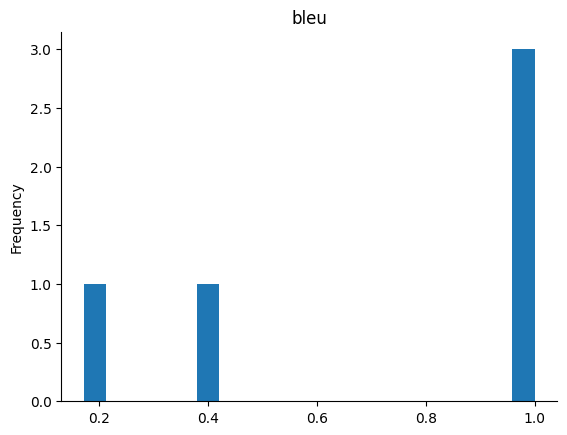

In [ ]:
from matplotlib import pyplot as plt
_df_0['bleu'].plot(kind='hist', bins=20, title='bleu')
plt.gca().spines[['top', 'right',]].set_visible(False)